## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Import csv data of taxi orders
data = pd.read_csv(
    './taxi.csv', index_col=[0], parse_dates=[0]
)
data.sort_index(inplace=True)

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
data = data.resample("1H").sum()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


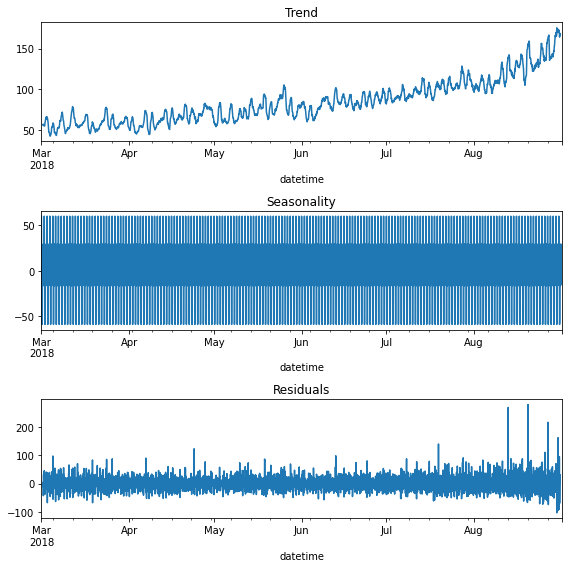

In [7]:
# Use seasonal_decompose to breakdown the time series into trend, seasonality, and residual components and plot them
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

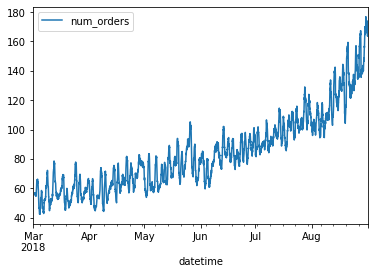

In [8]:
# Rolling mean plot, window is 24 hours
data.rolling(24).mean().plot()
plt.show()

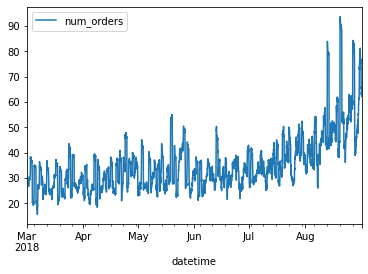

In [9]:
# Rolling std plot, window is 24 hours
data.rolling(24).std().plot()
plt.show()

Data is from March 1st 2018 to August 31st 2018 and shows number of taxi orders by hour. There are no missing values. This time series is non-stationary since the rolling mean and std trend up over time.

As shown in the decomposed plots and rolling mean plot, there's a clear trend, an increase in the hourly orders from May to August. Variation in number of hourly orders also increases from mid July to end of August.

## Analysis

In [10]:
# Function to create calendar, lag, and rolling mean features to be used in machine learning model

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

In [11]:
# Create features using make_features() function 
make_features(data, 168, 168)

After testing different models with different features, lag and rolling mean of 168 hours (7 days) reduces overfitting and improves model RMSE performance to meet goal.

In [12]:
# Check the data to ensure features added
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Training

In [13]:
# Function to calculate RMSE
def rmse(target,prediction):
    return mean_squared_error(target,prediction) ** 0.5

In [14]:
# Split data into training , combined validation and testing sets at 7:3 ratio
train, valid_and_test = train_test_split(data, shuffle=False, test_size=0.3)

# Drop null values created from lag and rolling mean features from training set
train = train.dropna()
features_train = train.drop('num_orders',axis=1)
target_train = train['num_orders']

# Split validation and test combined set into validation and test at 2:1 ratio
valid, test= train_test_split(valid_and_test, shuffle=False, test_size=0.3333)

features_valid = valid.drop('num_orders',axis=1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders',axis=1)
target_test = test['num_orders']

In [15]:
print(data.shape)
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(4416, 174)
(2923, 173) (2923,)
(883, 173) (883,)
(442, 173) (442,)


Test is 10%, validation is 20%, and train set is 70% of original data set

### Linear Regression

In [16]:
lr = LinearRegression()
lr.fit(features_train,target_train)

# Use validation set to make predictions and calculate RMSE
prediction_valid = lr.predict(features_valid)
print('RMSE:', rmse(target_valid,prediction_valid))

RMSE: 26.727915575245923


### Random Forest Regressor

In [17]:
rf = RandomForestRegressor(n_estimators=5, random_state=12345)
rf.fit(features_train,target_train) 
prediction_valid = rf.predict(features_valid)

print('RMSE:', rmse(target_valid,prediction_valid))

RMSE: 31.273848340649973


In [18]:
# Hyperparameter tuning

# Define parameter grid
param_grid = {
    'n_estimators': [15, 50, 100],
    'max_depth': [None, 10, 25]
}

# Initialize best_score and best_params
best_score = np.inf
best_params_rf = None

# Iterate over the parameter grid
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=12345)
        model.fit(features_train, target_train)
        prediction_valid = model.predict(features_valid)
        score = rmse(target_valid,prediction_valid)
        if score < best_score:
            best_score = score
            best_params_rf = {'n_estimators': n_estimators, 'max_depth': max_depth}

print(best_params_rf)

{'n_estimators': 100, 'max_depth': 10}


### Decision Tree

In [19]:
dt = DecisionTreeRegressor(random_state=12345)
dt.fit(features_train,target_train) 
prediction_valid = dt.predict(features_valid)

print('RMSE:', rmse(target_valid,prediction_valid))

RMSE: 36.99663294648749


In [20]:
# Hyperparameter tuning

# Define parameter grid
param_grid = {
    'max_depth': range(5,100,10)
}

# Initialize best_score and best_params
best_score = np.inf
best_params_dt = None

# Iterate over the parameter grid
for max_depth in param_grid['max_depth']:
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=12345)
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    score = rmse(target_valid,prediction_valid)
    if score < best_score:
        best_score = score
        best_params_dt = {'max_depth': max_depth}

print(best_params_dt)

{'max_depth': 5}


### CatBoost 

In [21]:
catboost_reg = CatBoostRegressor(iterations=100, random_seed=12345)

catboost_reg.fit(features_train, target_train, verbose=25)

prediction_valid = catboost_reg.predict(features_valid)

print('RMSE:', rmse(target_valid,prediction_valid))

Learning rate set to 0.315341
0:	learn: 29.0779418	total: 93.4ms	remaining: 9.25s
25:	learn: 16.3788977	total: 1.11s	remaining: 3.15s
50:	learn: 13.7506047	total: 2.1s	remaining: 2.02s
75:	learn: 11.5625909	total: 3.17s	remaining: 1s
99:	learn: 9.8564188	total: 4.14s	remaining: 0us
RMSE: 29.636277179786667


In [22]:
# Hyperparameter tuning

# Define parameter grid
param_grid = {
    'iterations': [100, 150, 200],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.1, 0.15, 0.2, 0.25]
}

# Initialize best_score and best_params
best_score = np.inf
best_params_catboost = None

# Iterate over the parameter grid
for iteration in param_grid['iterations']:
    for depth in param_grid['depth']:
        for learning_rate in param_grid['learning_rate']:
            model = CatBoostRegressor(iterations=iteration, depth=depth, learning_rate=learning_rate, random_seed=12345)
            model.fit(features_train, target_train, verbose=50)
            prediction_valid = model.predict(features_valid)
            score = rmse(target_valid,prediction_valid)
            if score < best_score:
                best_score = score
                best_params_catboost = {'iterations': iteration, 'depth': depth, 'learning_rate': learning_rate}

print(best_params_catboost)

0:	learn: 32.4183599	total: 18.5ms	remaining: 1.83s
50:	learn: 18.2997422	total: 842ms	remaining: 809ms
99:	learn: 17.0226407	total: 1.63s	remaining: 0us
0:	learn: 31.5948220	total: 17.4ms	remaining: 1.73s
50:	learn: 17.6556419	total: 841ms	remaining: 808ms
99:	learn: 15.9229788	total: 1.62s	remaining: 0us
0:	learn: 30.7975494	total: 16.7ms	remaining: 1.65s
50:	learn: 17.0525841	total: 836ms	remaining: 803ms
99:	learn: 15.0617775	total: 1.63s	remaining: 0us
0:	learn: 30.0286339	total: 17.6ms	remaining: 1.75s
50:	learn: 16.5319504	total: 826ms	remaining: 794ms
99:	learn: 14.2232732	total: 1.6s	remaining: 0us
0:	learn: 32.4241653	total: 47.1ms	remaining: 4.66s
50:	learn: 17.0954745	total: 2.12s	remaining: 2.04s
99:	learn: 15.4406937	total: 4.05s	remaining: 0us
0:	learn: 31.6024617	total: 50.3ms	remaining: 4.98s
50:	learn: 16.4597456	total: 2.08s	remaining: 2s
99:	learn: 13.9684659	total: 4.02s	remaining: 0us
0:	learn: 30.8062278	total: 46.1ms	remaining: 4.57s
50:	learn: 15.6294873	total:

## Testing

### Linear Regression

In [23]:
prediction_test = lr.predict(features_test)

print('RMSE:', rmse(target_test,prediction_test))

RMSE: 38.26976776157354


### Random Forest Regressor

In [24]:
# Random Forest model using best parameters from hypertuning above
rf = RandomForestRegressor(**best_params_rf, random_state=12345)
rf.fit(features_train,target_train) 
prediction_test = rf.predict(features_test)

print('RMSE:', rmse(target_test,prediction_test))

RMSE: 49.476141173476


### Decision Tree

In [25]:
# Decision Tree model using best parameters from hypertuning above

dt = DecisionTreeRegressor(**best_params_dt, random_state=12345)
dt.fit(features_train,target_train) 
prediction_test = dt.predict(features_test)

print('RMSE:', rmse(target_test,prediction_test))

RMSE: 57.43817712498621


### CatBoost 

In [26]:
# CatBoost model using best parameters from hypertuning above

catboost_reg = CatBoostRegressor(**best_params_catboost, random_seed=12345)
catboost_reg.fit(features_train, target_train, verbose=50)
prediction_test = catboost_reg.predict(features_test)

print('RMSE:', rmse(target_test,prediction_test))

0:	learn: 32.4183599	total: 19.5ms	remaining: 2.91s
50:	learn: 18.2997422	total: 831ms	remaining: 1.61s
100:	learn: 17.0001189	total: 1.64s	remaining: 796ms
149:	learn: 15.8250715	total: 2.43s	remaining: 0us
RMSE: 46.55176284776182


### Sanity Checks

In [27]:
# Constant median model

pred_median = pd.Series(target_train.median(), index=target_test.index)

print('RMSE:', rmse(target_test,pred_median))

RMSE: 91.68579534406244


In [28]:
# Model that predicts future value from previous value

pred_previous = target_test.shift(fill_value=target_train[-1])

print('RMSE:', rmse(target_test,pred_previous))

RMSE: 58.89896633468297


## Conclusions:

- Taxi hourly orders have seasonality and a clear trend of increasing orders starting from mid April through end of August
- Linear regression, Random Forest, Decision Tree, and CatBoost passed sanity checks
- Linear regression and CatBoost models meet the RMSE goal of less than 48
- Linear regression has the lowest RMSE, as other models are overfitted to the training and validation data, so LR should be used to predict taxi orders for the next hour